## 3D Delft3D Flow visuals
This is a big mess I've split this into seperate notebooks

In [2]:
import pyvista as pv
from pyvista import examples
import numpy as np
import xarray as xr
from JulesD3D.utils import quickDF
from cmocean.cm import deep
import PVGeo
from PVGeo.filters import VoxelizePoints

In [22]:
ncfilename = '/Users/julesblom/ThesisResults/5050_single_slope/Slope1.50/Run1_clean.nc'
trim = xr.open_dataset(ncfilename) # Open with xarray : DataSet : A collection of DataArrays

In [4]:
depth = trim.depth.isel(time=0)
depthcenter = trim.depthcenter.isel(time=0)

In [5]:
trim['layer_thickness'] = (depthcenter.dims, np.diff(depth.values))

In [6]:
velocity = trim.velocity.isel(time=-1).transpose('M', 'N', 'KMAXOUT_RESTR')
velocity.shape

(62, 202, 80)

In [7]:
density = trim.RHO.isel(time=-1).transpose('M', 'N', 'KMAXOUT_RESTR')
density.dims

('M', 'N', 'KMAXOUT_RESTR')

In [8]:
richardson_nr = trim.isel(time=-5).RICH.transpose('M', 'N', 'KMAXOUT')
richardson_nr.shape

(62, 202, 81)

In [9]:
vert_eddy_visc = trim.VICWW.isel(time=-2).transpose('M', 'N', 'KMAXOUT')

# PVGeo Point cloud approach
1. Repeat XZ and YZ mesh nr_sigma_interfaces time to get 3d XZ and YZ meshgrids of size (62, 202, 81)
2. Use Column_stack to make 62·202·81 tuples of x,y,z

https://docs.pyvista.org/core/filters.html?highlight=polydata#pyvista.PolyDataFilters

In [10]:
print('XZ\t\t', trim.XZ.T.shape)
print('YZ\t\t', trim.YZ.T.shape)
print('depth\t\t', depth.shape)

XZ		 (202, 62)
YZ		 (202, 62)
depth		 (62, 202, 81)


# Interfaces

In [11]:
nr_sigma_interfaces = trim.SIG_INTF.size

In [12]:
x_interfaces = np.repeat(trim.XZ.values[:,:, np.newaxis], nr_sigma_interfaces, axis=2)
y_interfaces = np.repeat(trim.YZ.values[:,:, np.newaxis], nr_sigma_interfaces, axis=2)

In [13]:
print("x_interfaces\t", x_interfaces.shape)
print("x_interfaces\t", y_interfaces.shape)
print("depth\t\t", depth.shape)

x_interfaces	 (62, 202, 81)
x_interfaces	 (62, 202, 81)
depth		 (62, 202, 81)


In [14]:
x_interface_ravel = np.ravel(x_interfaces)
y_interface_ravel = np.ravel(y_interfaces)

In [15]:
depth_ravel = np.ravel(depth.values)
# richardson_nr_ravel = np.ravel(richardson_nr.values)
vert_eddy_visc_ravel = np.ravel(vert_eddy_visc.values)

In [16]:
xyz_interfaces = np.column_stack((x_interface_ravel, y_interface_ravel, depth_ravel))
xyz_interfaces.shape

(1014444, 3)

In [17]:
xyz_interfaces_polydata = PVGeo.points_to_poly_data(xyz_interfaces)

In [18]:
xyz_interfaces_polydata

PolyData,Information
N Cells,1014444
N Points,1014444
X Bounds,"0.000e+00, 1.815e+04"
Y Bounds,"-5.000e+01, 6.025e+04"
Z Bounds,"-8.798e+02, 0.000e+00"
N Arrays,0


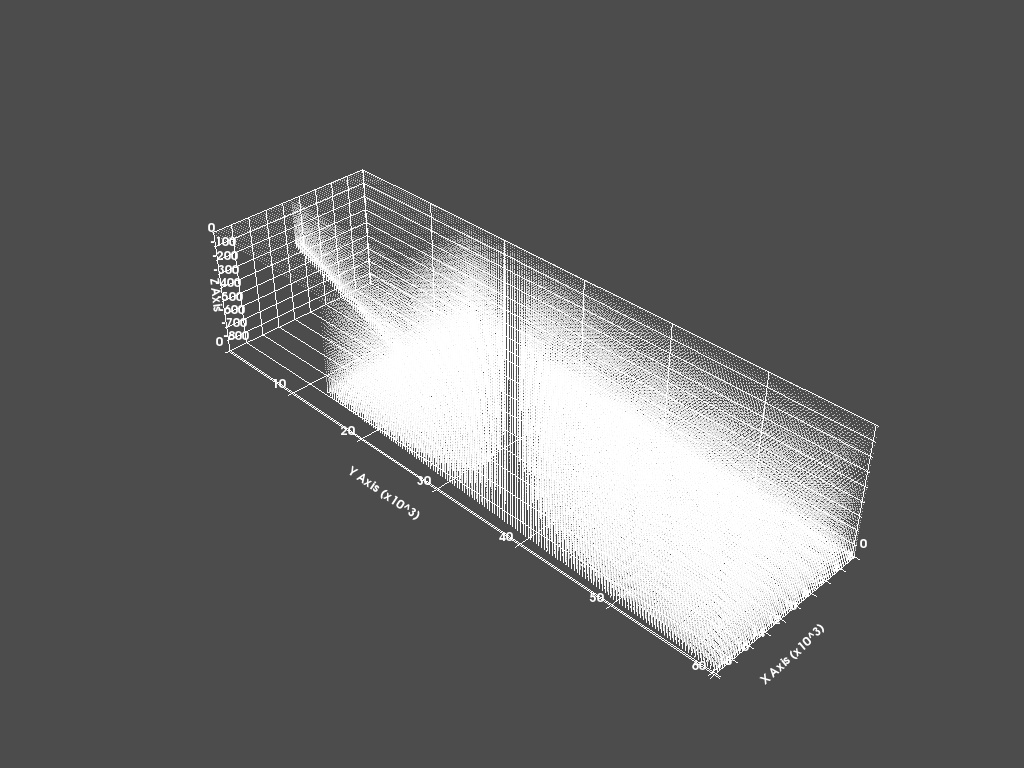

In [21]:
p = pv.Plotter()
p.add_mesh(xyz_interfaces_polydata, opacity=0.6, point_size=0.01, show_edges=True)
p.enable_depth_peeling(20)
p.show_grid()
p.set_scale(zscale=15)
p.show()

# Centers

In [18]:
plot_x_mesh = trim.XZ.values[:-1,:-1]
plot_y_mesh = trim.YZ.values[:-1,:-1]
plot_z_mesh = -trim.DP0.values[:-1,:-1]
plot_bottom_stress = trim.bottom_stress.isel(time=-5).values[:-1,:-1].T
grid = pv.StructuredGrid(plot_x_mesh, plot_y_mesh, plot_z_mesh)
grid.field_arrays['bottom_stress'] = plot_bottom_stress

In [19]:
nr_sigma_layers = trim.SIG_LYR.size

In [20]:
x_centers = x_interfaces[:,:,:-1]
y_centers = y_interfaces[:,:,:-1]

In [21]:
x_centers_ravel = np.ravel(x_centers)
y_centers_ravel = np.ravel(y_centers)
depthcenter_ravel = np.ravel(depthcenter.values)
depthcenter_ravel.shape

(1001920,)

In [22]:
density_ravel = np.ravel(density.values)
density_ravel.shape

(1001920,)

In [23]:
velocity_ravel = np.ravel(velocity.values)
velocity_ravel.shape

(1001920,)

In [24]:
xyz_centers = np.column_stack((x_centers_ravel, y_centers_ravel, depthcenter_ravel))
xyz_centers.shape

(1001920, 3)

In [25]:
xyz_centers_polydata = pv.PolyData(xyz_centers)
xyz_centers_polydata["density"] = density_ravel.T
xyz_centers_polydata["velocity"] = velocity_ravel.T

In [26]:
# clipped_centers = xyz_centers_polydata.clip('z')
threshed_density_centers = xyz_centers_polydata.threshold([1025.2, 1050], scalars="density")
threshed_velocity_centers = threshed_density_centers.threshold([0.1, 6], scalars="velocity")
threshed_velocity_centers

UnstructuredGrid (0x12eb41280)
  N Cells:	5630
  N Points:	5630
  X Bounds:	5.850e+03, 1.215e+04
  Y Bounds:	7.450e+03, 2.095e+04
  Z Bounds:	-7.436e+02, -5.258e+02
  N Arrays:	2

In [27]:
p_density = pv.BackgroundPlotter()
# p_density = pv.Plotter()
p_density.add_mesh(grid, scalars='bottom_stress', cmap=deep, interpolate_before_map=False)
p_density.add_mesh(threshed_density_centers, scalars='density', cmap='viridis', point_size=15, opacity=0.7) #, \
# p_density.add_mesh(threshed_velocity_centers, scalars='velocity', cmap='inferno', point_size=25, opacity=0.1) #, \
p_density.show_grid()
p_density.set_scale(zscale=5)
panel = p_density.show()